In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/qbo_data.csv",index_col="run_id")
df = df.sort_values("qbo_period_std")
df

,cw,Bt,qbo_periods,qbo_period_std,qbo_period_fft,qbo_count,qbo_rmse_ampltiude,qbo_amplitude_mean,qbo_amplitude_std
run_id,,,,,,,,,
78,63.111004,0.002280,11.466667,3.984022e-15,11.466667,19,12.475006,17.731903,0.000000
1,44.617037,0.005099,24.116463,8.522248e-01,24.000000,9,42.536683,39.017867,1.996191
64,49.812074,0.005277,23.683767,8.823445e-01,24.000000,9,46.075949,42.475577,1.897165
60,21.845038,0.006956,19.117979,1.263149e+00,18.461538,12,34.874135,35.291554,1.546429
15,33.698484,0.005147,24.227832,1.284637e+00,24.000000,9,40.913906,38.525333,2.027852
...,...,...,...,...,...,...,...,...,...
35,8.580488,0.005694,18.281435,1.201578e+01,26.666667,12,12.293360,11.247630,4.733746
52,17.041039,0.001164,28.288639,1.384765e+01,12.000000,8,10.699096,11.159743,3.234233
44,5.930840,0.004727,27.009087,1.428539e+01,12.000000,8,10.644768,11.106186,1.924817


## Constants

In [3]:
OBS_PERIOD_MEAN = 27.915249015787193
OBS_PERIOD_STD = 4.538404428603899
OBS_PERIOD_SEM = 0.8576778190800078

OBS_AMP_MEAN = 26.587500000000002
OBS_AMP_STD =2.953799762291663
OBS_AMP_SEM = 0.5582156852646746

CURRENT_CW = 35
CURRENT_BT = 0.0043

## todo
* combine all these operations into a single pipeline that transforms X,y directly -> predicts in natural space
* Move this architecture to proper py module file

In [4]:

import numpy as np
X = df[["Bt","cw"]].to_numpy()
y_point_error = df[["qbo_period_std","qbo_amplitude_std"]].to_numpy()
y_point_error = y_point_error/np.sqrt(df['qbo_count'].to_numpy()[:,None])
y = df[["qbo_periods","qbo_amplitude_mean"]].to_numpy()

mean_y = np.mean(y,axis=0)
std_y = np.std(y,axis=0)
y_norm = (y - mean_y)/std_y
y_point_error = y_point_error/std_y

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor

gpr_period = GaussianProcessRegressor(alpha=(y_point_error[:,0])**2)
gpr_amplitude = GaussianProcessRegressor(alpha=(y_point_error[:,1])**2)
gpr_period.fit(X_scaled,y_norm[:,0])
gpr_amplitude.fit(X_scaled,y_norm[:,1])


GaussianProcessRegressor(alpha=array([0.        , 0.00394444, 0.0035628 , 0.00177543, 0.00407056,
       0.01111182, 0.00528394, 0.00234144, 0.00981926, 0.00229411,
       0.00484907, 0.00205966, 0.00413397, 0.00333008, 0.0027204 ,
       0.00495614, 0.0046492 , 0.00415858, 0.01003946, 0.00686253,
       0.00424828, 0.01199633, 0.00143149, 0.01002375, 0.00181131,
       0.00269239, 0.00354141, 0.00451715, 0.00284375, 0.00...
       0.0068215 , 0.00540582, 0.00348509, 0.00486593, 0.03407311,
       0.02047412, 0.00650604, 0.00540374, 0.0633237 , 0.00922684,
       0.02505733, 0.00091987, 0.01889161, 0.00960934, 0.00615827,
       0.05312333, 0.0585899 , 0.01271577, 0.04736922, 0.00637439,
       0.0569585 , 0.02081227, 0.01006019, 0.00590188, 0.0111363 ,
       0.00842052, 0.00487103, 0.00597181, 0.00456573, 0.06686673,
       0.01663614, 0.01164868, 0.00412584, 0.0083599 , 0.01683585]))

In [8]:
predval,predstd = gpr_period.predict(scaler.transform([[0.0043,35]]),return_std=True)
predval = predval*std_y[0] + mean_y[0]
predstd = predstd*std_y[0]

In [9]:
predval,predstd

(array([25.58962086]), array([0.3170048]))

### 3D Plots?

In [10]:
CW_POINTS = 1000
BT_POINTS = 1000
cw = np.linspace(5,70,CW_POINTS)
Bt = np.linspace(0.001,0.007,BT_POINTS)
X_Bt,Y_cw = np.meshgrid(Bt,cw)
x_samples = np.vstack((X_Bt.ravel(),Y_cw.ravel())).T
x_samples = scaler.transform(x_samples)


In [11]:
period,period_std = gpr_period.predict(x_samples,return_std=True)
period = period*std_y[0] + mean_y[0]
period = period.reshape((CW_POINTS,BT_POINTS))
period_std = (period_std*std_y[0]).reshape((CW_POINTS,BT_POINTS))


amplitude,amplitude_std = gpr_amplitude.predict(x_samples,return_std=True)
amplitude = amplitude*std_y[1] + mean_y[1]
amplitude = amplitude.reshape((CW_POINTS,BT_POINTS))
amplitude_std = (amplitude_std*std_y[1]).reshape((CW_POINTS,BT_POINTS))

In [12]:
implausability_period = np.abs(period - OBS_PERIOD_MEAN)/np.sqrt(OBS_PERIOD_SEM**2 + period_std**2)
implausability_amplitude = np.abs(amplitude - OBS_AMP_MEAN)/np.sqrt(OBS_AMP_SEM**2 + amplitude_std**2)
implausability = np.sqrt(implausability_amplitude**2 + implausability_period**2)

In [13]:
imp_cutoff = implausability < 3

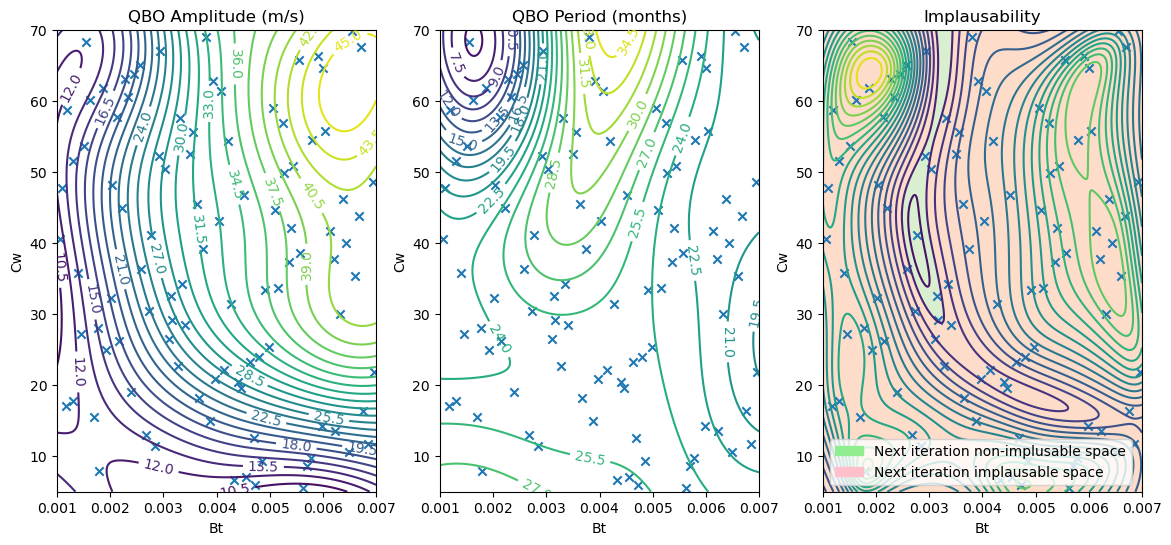

In [14]:
import matplotlib.patches as mpatches

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,6))
#ax1.contourf(X_Bt,Y_cw,amp_region,levels=3,colors=['#ffffff00','#000000ff'],hatches=[None,'x'],alpha=0.1)
CS = ax1.contour(X_Bt,Y_cw,amplitude,levels=25)

ax1.scatter(X[:,0],X[:,1],marker='x')
ax1.clabel(CS, CS.levels, inline=True,  fontsize=10)
ax1.set_ylabel("Cw")
ax1.set_xlabel("Bt")
ax1.set_title("QBO Amplitude (m/s)")

#ax2.contourf(X_Bt,Y_cw,period_region,levels=3,colors=['#ffffff00','#000000ff'],hatches=[None,'x'],alpha=0.1)
CS2 = ax2.contour(X_Bt,Y_cw,period,levels=25)
ax2.scatter(X[:,0],X[:,1],marker='x')
ax2.clabel(CS2, CS2.levels, inline=True,  fontsize=10)
ax2.set_ylabel("Cw")
ax2.set_xlabel("Bt")
ax2.set_title("QBO Period (months)")

ax3.contour(X_Bt,Y_cw,implausability,levels=25)
CS3 = ax3.contourf(X_Bt,Y_cw,imp_cutoff,alpha=0.3,cmap='RdYlGn',levels=1)
ax3.scatter(X[:,0],X[:,1],marker='x')
ax3.set_ylabel("Cw")
ax3.set_xlabel("Bt")
ax3.legend(handles=[mpatches.Patch(color='lightgreen',label="Next iteration non-implusable space"),
                    mpatches.Patch(color='pink',label="Next iteration implausable space")])
ax3.set_title("Implausability")

fig.savefig("wave1_alt.png")

Text(0.5, 0, 'Implausability')

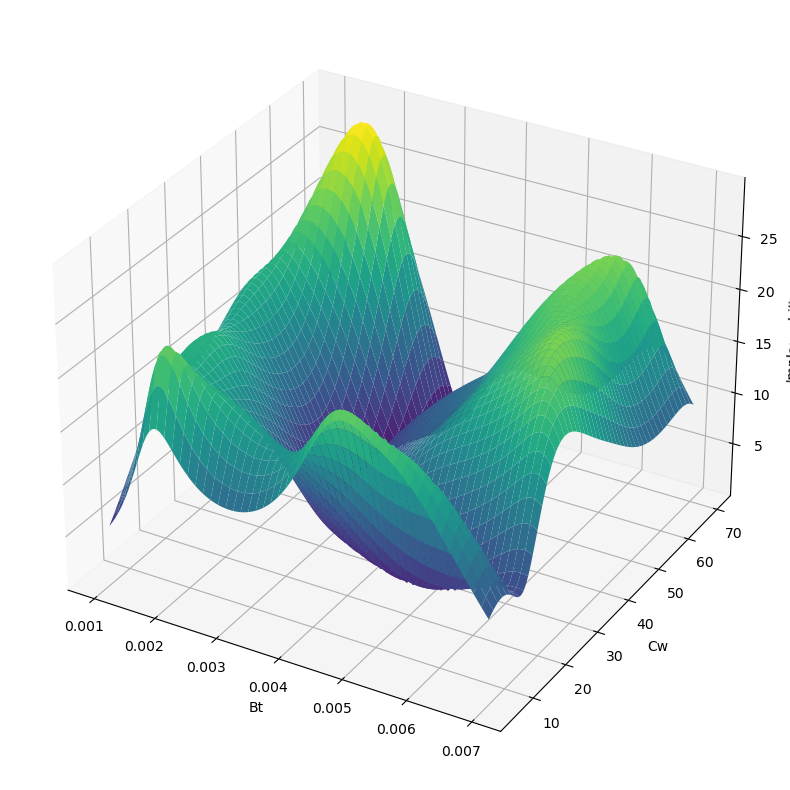

In [15]:
from mpl_toolkits.mplot3d import axes3d
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.plot_surface(X_Bt,Y_cw,implausability,cmap='viridis')
ax.set_xlabel("Bt")
ax.set_ylabel("Cw")
ax.set_zlabel("Implausability")

## Calculate Decision Boundary + Sampling

In [20]:
def get_new_samples(new_sample_space,X,Y,n_samples=100):
    """
    MCMC sampling.
    Probably not very good 
    Dimensions of new_sample_space,X,Y, must match
    """
    ## Calculating bounding box of new_sample_space.
    y_where,x_where = np.where(new_sample_space)
    x_min,x_max,y_min,y_max = X[0,np.min(x_where)],X[0,np.max(x_where)],Y[np.min(y_where),0],Y[np.max(y_where),0]
    new_samples = []
    while len(new_samples) < n_samples:
        # Sample random point in original sample space 
        x,y = np.random.uniform(low=(x_min,y_min),high=(x_max,y_max))
        col = np.argmin(np.abs(X-x),axis=1)[1]
        row = np.argmin(np.abs(Y-y),axis=0)[0]
        if new_sample_space[row,col]:
            new_samples.append((x,y))
        # Check sample point meets plausability criterion
    return np.array(new_samples)


In [21]:
new_samples = get_new_samples(imp_cutoff,X_Bt,Y_cw)
pd.DataFrame(new_samples,columns=("Bt","cw")).to_csv("../data/rounds/mcmc_round2_samples_3sigma.csv")


### LHS

In [22]:
from pyDOE import lhs

def get_new_samples_lhs(new_sample_space,X,Y,n_samples=100,max_iter=1000):
    """
    MCMC sampling.
    Probably not very
    Dimensions of new_sample_space,X,Y, must match
    """
    ## Calculating bounding box of new_sample_space.
    y_where,x_where = np.where(new_sample_space)
    x_min,x_max,y_min,y_max = X[0,np.min(x_where)],X[0,np.max(x_where)],Y[np.min(y_where),0],Y[np.max(y_where),0]
    
    rescale = np.array([[x_max -x_min,0],[0,y_max-y_min],[x_min,y_min]])
    for i in range(1,max_iter):
        # Sample random point in original sample space 
        samples = lhs(2,samples=n_samples*i*5,criterion='m')
        samples = np.column_stack((samples,np.ones(n_samples*i*5))) @ rescale
        print(samples[:,1].min())
        rows,cols = (np.argmin(np.abs(Y[:,0,None] - samples[:,1][None,:]),axis=0),
                                  np.argmin(np.abs(X[0,:,None] - samples[:,0][None,:]),axis=0))
        valid = new_sample_space[cols,rows]
        if np.sum(valid) >= n_samples:
            ys,xs = Y[cols[valid],0],X[0,rows[valid]]
            return np.column_stack((xs,ys))
    raise RuntimeError(f"Unable to draw {n_samples} samples in {max_iter} iterations from the sample space")


In [19]:
lhs_samples = get_new_samples_lhs(imp_cutoff,X_Bt,Y_cw)

28.75906445114097
28.781873662652046
28.75434187846597
28.76816652692123
28.750825923731007
28.75178970459576
28.757375865917265
28.750984363512426
28.74919691120685
28.750525122423888


KeyboardInterrupt: 

In [ ]:
lhs_samples

array([[4.60360360e-03, 1.97697698e+01],
       [3.19219219e-03, 3.09609610e+01],
       [3.22822823e-03, 3.03753754e+01],
       [3.07807808e-03, 4.67717718e+01],
       [2.43543544e-03, 3.83133133e+01],
       [2.93393393e-03, 3.55155155e+01],
       [4.24324324e-03, 2.00950951e+01],
       [3.30030030e-03, 2.67317317e+01],
       [2.84384384e-03, 5.21071071e+01],
       [2.57357357e-03, 4.61211211e+01],
       [3.61261261e-03, 2.86836837e+01],
       [2.95795796e-03, 3.40840841e+01],
       [4.22522523e-03, 2.16566567e+01],
       [3.16216216e-03, 2.95295295e+01],
       [3.27627628e-03, 3.68168168e+01],
       [2.80180180e-03, 4.12412412e+01],
       [3.07807808e-03, 5.44494494e+01],
       [2.90990991e-03, 3.74024024e+01],
       [2.46546547e-03, 4.90490490e+01],
       [2.47147147e-03, 4.29329329e+01],
       [3.11411411e-03, 4.57957958e+01],
       [2.98798799e-03, 3.30430430e+01],
       [3.29429429e-03, 2.91391391e+01],
       [2.82582583e-03, 3.05055055e+01],
       [3.060060

NameError: name 'lhs_samples' is not defined

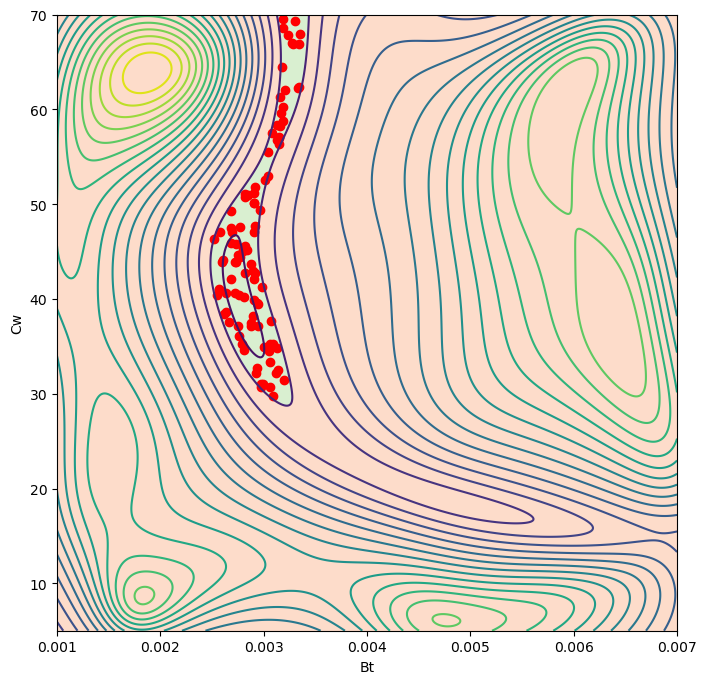

In [23]:
fig,(ax1) = plt.subplots(figsize=(8,8))


ax1.contour(X_Bt,Y_cw,implausability,levels=25)
ax1.contourf(X_Bt,Y_cw,imp_cutoff,alpha=0.3,cmap='RdYlGn',levels=1)
#ax1.scatter(CURRENT_BT,CURRENT_CW)
ax1.set_ylabel("Cw")
ax1.set_xlabel("Bt")
ax1.scatter(new_samples[:,0],new_samples[:,1],c='r',label="MCMC")
ax1.scatter(lhs_samples[:,0],lhs_samples[:,1],c='g',label="Latin Hypercube")
ax1.legend()

In [ ]:
import xarray
imp_cutoff = xarray.DataArray(data=imp_cutoff,dims=['x','y'],coords={"Bt":(['x','y'],X_Bt),"cw":(['x','y'],Y_cw)})
implausability = xarray.DataArray(data=implausability,dims=['x','y'],coords={"Bt":(['x','y'],X_Bt),"cw":(['x','y'],Y_cw)})
period = xarray.DataArray(data=period,dims=['x','y'],coords={"Bt":(['x','y'],X_Bt),"cw":(['x','y'],Y_cw)})
amplitude = xarray.DataArray(data=amplitude,dims=['x','y'],coords={"Bt":(['x','y'],X_Bt),"cw":(['x','y'],Y_cw)})

In [ ]:
ds = xarray.Dataset({"imp_cutoff":imp_cutoff,"implausability":implausability,"qbo_amplitude":amplitude,"qbo_period":period})

In [ ]:
ds.to_netcdf("wave1_predictions_3sig.nc")